# Boletín 5: Máquinas de Soporte Vectorial

## Importamos las librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')

# Para evitar warnings en algunas gráficas
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

## Definimos variables globales

In [3]:
SEED_VALUE = 1  # Valor que se indica en el boletín
DATASET_DELIMITER = ',' # Ambos bloodTransfusion.data y EnergyEfficiency.data lo usan

## Ejercicio 1: Soporte Vectorial sin scikit-learn

Vamos a definir los datos dados en el boletin

In [101]:
datos = [
    [2, 6, 1, 0],
    [4, 3, 1, 1],
    [4, 4, 1, 0.3333],
    [4, 6, 1, 0],
    [6, 3, 1, 1],
    [7, 7, 1, 0.1667],
    [8, 4, 1, 1],
    [9, 8, 1, 1],
    [2, 1, -1, 1],
    [6, 2, -1, 0.5],
    [7, 4, -1, 1],
    [8, 8, -1, 1],
    [9, 1, -1, 0],
    [10, 3, -1, 0],
    [10, 6, -1, 1],
    [12, 4, -1, 0]
]

C = 1

### Apartado a: Cuáles son los vectores de soporte y cuáles de ellos están en el límite del margen?

Los vectores de soporte son aquellos para el cual el valor de a_i > 0, por lo que los vectores de soporte de datos son:

In [100]:
for indice, vector in enumerate(datos):
    if vector[3] > 0:
        print("Vector número {}: {}".format(indice + 1, vector))

Vector número 2: [4, 3, 1, 1]
Vector número 3: [4, 4, 1, 0.3333]
Vector número 5: [6, 3, 1, 1]
Vector número 6: [7, 7, 1, 0.1667]
Vector número 7: [8, 4, 1, 1]
Vector número 8: [9, 8, 1, 1]
Vector número 9: [2, 1, -1, 1]
Vector número 10: [6, 2, -1, 0.5]
Vector número 11: [7, 4, -1, 1]
Vector número 12: [8, 8, -1, 1]
Vector número 15: [10, 6, -1, 1]


Los vectores que están en el límite del margen son aquellos para los cuales el valor de a_i cumple 0 < a_i < C con C=1.

In [115]:
for indice, vector in enumerate(datos):
    if 0 < vector[3] < C:
        print("Vector número {}: {}".format(indice + 1, vector))

Vector número 3: [4, 4, 1, 0.3333]
Vector número 6: [7, 7, 1, 0.1667]
Vector número 10: [6, 2, -1, 0.5]


### Apartado b: Cuáles son los coeficientes del hiperplano (β y β0) y el valor de M

Para calcular M primero necesitamos calcular beta

In [108]:
datos_numpy = np.array(datos)

# Calculamos beta
coef_beta_1 = np.sum(datos_numpy[:, 3] * datos_numpy[:, 2] * datos_numpy[:, 0])
coef_beta_2 = np.sum(datos_numpy[:, 3] * datos_numpy[:, 2] * datos_numpy[:, 1])
coeficientes_beta = (coef_beta_1, coef_beta_2)

print("Coeficientes beta: {}".format(coeficientes_beta))

Coeficientes beta: (-0.49990000000000023, 0.5000999999999998)


Y calcular beta_0

In [109]:
# Calculamos beta_0
puntos_margen = datos_numpy[0 < datos_numpy[:, 3], :]
puntos_margen = puntos_margen[puntos_margen[:, 3] < C, :]
valor_beta_0 = []
for punto in puntos_margen:
    valor_beta_0.append((1.0 / punto[2]) - np.dot(punto[0:2], coeficientes_beta))
beta_0_promedio = np.mean(valor_beta_0)

print("Beta_0 promedio: {}".format(beta_0_promedio))

Beta_0 promedio: 0.999


Ahora podemos calcular M

In [110]:
# Calculamos el Margen M
margen_M = 1.0 / np.linalg.norm(coeficientes_beta)
print("Margen M: {}".format(margen_M))

Margen M: 1.41421353409


### Apartado c: Los valores de εi y las observaciones incorrectamente clasificadas

Primero vamos a calcular los valores de epsilon

In [113]:
# Inicialización de epsilon
margen_epsilon = np.zeros(datos_numpy.shape[0])

# Calculamos epsilon para cada fila
for indice, fila in enumerate(datos_numpy):
    if fila[3] != 0:
        margen_epsilon[indice] = 1.0 - fila[2] * (np.dot(fila[0:2], coeficientes_beta) + beta_0_promedio)

print("Valores de epsilon: {}".format(margen_epsilon))

Valores de epsilon: [ 0.0000e+00  5.0030e-01  2.0000e-04  0.0000e+00  1.5001e+00 -4.0000e-04
  1.9998e+00  4.9930e-01  1.4993e+00 -2.0000e-04  5.0010e-01  2.0006e+00
  0.0000e+00  0.0000e+00  6.0000e-04  0.0000e+00]


Con los epsilon calculados podemos identificar los puntos incorrectamente clasificados

In [114]:
print("Puntos incorrectamente clasificados:")
for indice, fila in enumerate(datos_numpy):
    if margen_epsilon[indice] > 1:
        print("Punto número {}: {}".format(indice + 1, fila))

Puntos incorrectamente clasificados:
Punto número 5: [6. 3. 1. 1.]
Punto número 7: [8. 4. 1. 1.]
Punto número 9: [ 2.  1. -1.  1.]
Punto número 12: [ 8.  8. -1.  1.]


## Ejercicio 2: Redes neuronales con Blood Transfusion Service Center

In [6]:
df_2 = pd.read_csv("bloodTransfusion.data", 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1,
                      header=None,
                      names = ["Recency", "Frequency", "Monetary", "Time", "DonatedInMarch"])
df_2

Recency  Frequency  Monetary  Time  DonatedInMarch
0          2         50     12500    98               1
1          0         13      3250    28               1
2          1         16      4000    35               1
3          2         20      5000    45               1
4          1         24      6000    77               0
5          4          4      1000     4               0
6          2          7      1750    14               1
7          1         12      3000    35               0
8          2          9      2250    22               1
9          5         46     11500    98               1
10         4         23      5750    58               0
11         0          3       750     4               0
12         2         10      2500    28               1
13         1         13      3250    47               0
14         2          6      1500    15               1
15         2          5      1250    11               1
16         2         14      3500    48               1
17         2         15      3750    49               1
18         2          6      1500    15               1
19         2          3       750     4               1
20         2          3       750     4               1
21         4         11      2750    28               0
22         2          6      1500    16               1
23         2          6      1500    16               1
24         9          9      2250    16               0
25         4         14      3500    40               0
26         4          6      1500    14               0
27         4         12      3000    34               1
28         4          5      1250    11               1
29         4          8      2000    21               0
..       ...        ...       ...   ...             ...
718       21          3       750    35               0
719       23          8      2000    69               0
720       21          3       750    38               0
721       23          3       750    35               0
722       21          3       750    40               0
723       23          2       500    28               0
724       21          1       250    21               0
725       21          1       250    21               0
726       25          6      1500    50               0
727       21          1       250    21               0
728       21          1       250    21               0
729       23          3       750    39               0
730       21          2       500    33               0
731       14          3       750    79               0
732       23          1       250    23               1
733       23          1       250    23               0
734       23          1       250    23               0
735       23          1       250    23               0
736       23          1       250    23               0
737       23          1       250    23               0
738       23          1       250    23               0
739       23          4      1000    52               0
740       23          1       250    23               0
741       23          7      1750    88               0
742       16          3       750    86               0
743       23          2       500    38               0
744       21          2       500    52               0
745       23          3       750    62               0
746       39          1       250    39               0
747       72          1       250    72               0

[748 rows x 5 columns]

### Apartado a: La clase que implementa las SVM en problemas de clasificación en scikit-learn es sklearn.svm.SVC

In [117]:
help(SVC)

Help on class SVC in module sklearn.svm.classes:

class SVC(sklearn.svm.base.BaseSVC)
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to dataset with more than a couple of 10000 samples.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  other, see the corresponding section in the narrative documentation:
 |  :ref:`svm_kernels`.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  C : float, optional (default=1.0)
 |      Penalty parameter C of the error term.
 |  
 |  kernel : string, optional (default='rbf')
 |      Specifies the kernel type to be used in the algorithm.
 |      It must be one of 'linear', 'poly',

### Apartado b: Divide los datos en entrenamiento (80%) y test (20%)

Dividimos los datos en variables predictoras X y la variable dependiente Y

In [7]:
X = df_2.drop('DonatedInMarch', axis=1)
Y = df_2['DonatedInMarch']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED_VALUE, stratify=Y)

Vamos también a estandarizar los datos, en este caso solo las variables predictoras ya que se trata de un problema de clasificación.

In [8]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """
/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


### Apartado c: Realiza la experimentación con SVC usando los valores por defecto de los parámetros, excepto para los siguientes hiper-parámetros

Las variables de los hyperparametros son:

In [118]:
# Para linear y rbf
c = [10**i for i in range(-10, 10, 1)]

# Para el kernel rbf
gamma = [10**i for i in range(-10, 10, 1)]

print(c)
print(gamma)

[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000]
[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000]


In [120]:
# Para poly
c_poly = [10**i for i in range(-6, 6, 1)]
# c_poly = [10**i for i in range(-6, 6, 1)] # Intenté llegar a 10^6 pero tras 27h de cálculos se perdió la conexión

# Para el kernel poly
degree = range(2, 5, 1)

print(c_poly)
print(degree)

[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
[2, 3, 4]


Datos del Hiperparámetro con menor error de validación cruzada y mas simple

**Muestra la gráfica del error de test frente al valor de los hiper‐parámetros (siguiendo el mismo esquema que en el apartado anterior), y valora si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de test.**

Vamos a extraer el menor valor de test:

In [9]:
# Para los tres kernels
c = [10**i for i in range(-10, 10, 1)]
# c = [10**i for i in range(-2, 2, 2)]

# Para el kernel rbf
gamma = [10**i for i in range(-10, 10, 1)]
# gamma = [10**i for i in range(-4, 5, 1)]

print(c)
print(gamma)

[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000]
[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000]


## LINEAR

Creamos la estructura de hiperparametros necesaria

In [10]:
hyperparameters_linear = {
    'kernel': ['linear'],
    'C': c
}

hyperparameters_linear

{'C': [1e-10,
  1e-09,
  1e-08,
  1e-07,
  1e-06,
  1e-05,
  0.0001,
  0.001,
  0.01,
  0.1,
  1,
  10,
  100,
  1000,
  10000,
  100000,
  1000000,
  10000000,
  100000000,
  1000000000],
 'kernel': ['linear']}

Ejecutamos el entrenamiento

In [22]:
%%time
# Medimos el tiempo de ejecucion
svm = SVC(random_state = SEED_VALUE)
modelCV_linear = GridSearchCV(
    svm,
    hyperparameters_linear,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1,
    verbose=4
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_linear.fit(X_train_scaled, Y_train)


Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  85 out of 105 | elapsed: 44.7min remaining: 10.5min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 150.6min finished


CPU times: user 3min 58s, sys: 417 ms, total: 3min 58s
Wall time: 2h 46min 21s


Debido al alto coste temporal de su cálculo, vamos a guardar el modelo con pickle

In [23]:
# NO descomentar a no ser que se está seguro de queres sobreescribir el valor guardado
# with open('models_2/modelCV_linear.pkl', 'wb') as file:
#     pickle.dump(modelCV_linear, file)

In [93]:
with open('models_2/modelCV_linear.pkl', 'rb') as file:
    modelCV_linear = pickle.load(file)

Podemos ver los resultados, primero invertimos mean_test_score y despues ordenamos por el mejor ranking obtenido

In [94]:
cv_results_linear = pd.DataFrame(modelCV_linear.cv_results_)
cv_results_linear['mean_test_score'] = 1 - cv_results_linear['mean_test_score']
cv_results_linear

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0        0.003652         0.001007         0.237458          0.762543   
1        0.003589         0.000964         0.237458          0.762543   
2        0.006002         0.000956         0.237458          0.762543   
3        0.003587         0.000962         0.237458          0.762543   
4        0.003544         0.000947         0.237458          0.762543   
5        0.004394         0.001473         0.237458          0.762543   
6        0.006315         0.001262         0.237458          0.762543   
7        0.005561         0.001326         0.237458          0.762543   
8        0.003752         0.000962         0.237458          0.762543   
9        0.006226         0.001001         0.239130          0.764213   
10       0.010176         0.001024         0.239130          0.764213   
11       0.028260         0.001065         0.239130          0.764213   
12       0.218656         0.001357         0.239130          0.764213   
13      28.247938         0.001664         0.239130          0.764213   
14      51.998189         0.001956         0.239130          0.764213   
15     143.962413         0.001955         0.234114          0.768390   
16     415.287178         0.001885         0.232441          0.767143   
17     489.190179         0.001822         0.250836          0.747087   
18     340.787699         0.001709         0.239130          0.760878   
19     586.333980         0.001782         0.245819          0.755429   

       param_C param_kernel                                    params  \
0        1e-10       linear       {u'kernel': u'linear', u'C': 1e-10}   
1        1e-09       linear       {u'kernel': u'linear', u'C': 1e-09}   
2        1e-08       linear       {u'kernel': u'linear', u'C': 1e-08}   
3        1e-07       linear       {u'kernel': u'linear', u'C': 1e-07}   
4        1e-06       linear       {u'kernel': u'linear', u'C': 1e-06}   
5        1e-05       linear       {u'kernel': u'linear', u'C': 1e-05}   
6       0.0001       linear      {u'kernel': u'linear', u'C': 0.0001}   
7        0.001       linear       {u'kernel': u'linear', u'C': 0.001}   
8         0.01       linear        {u'kernel': u'linear', u'C': 0.01}   
9          0.1       linear         {u'kernel': u'linear', u'C': 0.1}   
10           1       linear           {u'kernel': u'linear', u'C': 1}   
11          10       linear          {u'kernel': u'linear', u'C': 10}   
12         100       linear         {u'kernel': u'linear', u'C': 100}   
13        1000       linear        {u'kernel': u'linear', u'C': 1000}   
14       10000       linear       {u'kernel': u'linear', u'C': 10000}   
15      100000       linear      {u'kernel': u'linear', u'C': 100000}   
16     1000000       linear     {u'kernel': u'linear', u'C': 1000000}   
17    10000000       linear    {u'kernel': u'linear', u'C': 10000000}   
18   100000000       linear   {u'kernel': u'linear', u'C': 100000000}   
19  1000000000       linear  {u'kernel': u'linear', u'C': 1000000000}   

    rank_test_score  split0_test_score  split0_train_score       ...         \
0                 3           0.760331            0.763103       ...          
1                 3           0.760331            0.763103       ...          
2                 3           0.760331            0.763103       ...          
3                 3           0.760331            0.763103       ...          
4                 3           0.760331            0.763103       ...          
5                 3           0.760331            0.763103       ...          
6                 3           0.760331            0.763103       ...          
7                 3           0.760331            0.763103       ...          
8                 3           0.760331            0.763103       ...          
9                12           0.760331            0.763103       ...          
10               12           0.760331            0.763103       ..

In [95]:
cv_results_linear.loc[:, [
    'param_C',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')

param_C  mean_test_score  std_test_score  rank_test_score
16     1000000         0.232441        0.029548                1
15      100000         0.234114        0.009976                2
0        1e-10         0.237458        0.002709                3
1        1e-09         0.237458        0.002709                3
2        1e-08         0.237458        0.002709                3
3        1e-07         0.237458        0.002709                3
4        1e-06         0.237458        0.002709                3
5        1e-05         0.237458        0.002709                3
6       0.0001         0.237458        0.002709                3
7        0.001         0.237458        0.002709                3
8         0.01         0.237458        0.002709                3
14       10000         0.239130        0.003370               12
13        1000         0.239130        0.003370               12
9          0.1         0.239130        0.003370               12
11          10         0.239130        0.003370               12
10           1         0.239130        0.003370               12
18   100000000         0.239130        0.033390               12
12         100         0.239130        0.003370               12
19  1000000000         0.245819        0.020988               19
17    10000000         0.250836        0.033115               20

**Aqui tenemos el mejor valor**

In [14]:
cv_results_linear_best = cv_results_linear[cv_results_linear['rank_test_score'] == 1]

cv_results_linear_best.loc[:, [
    'param_C',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
].sort_values(
    by='param_C',
    ascending=True
).head()

param_C  mean_test_score  std_test_score  rank_test_score
16  1000000         0.232441        0.029548                1

**Muestra las gráficas del error de entrenamiento con validación cruzada (5‐CV) frente al valor de los hiper‐parámetros**

In [121]:
def plot_errors_validation(cv_results_linear, min_C_value):
    plt.figure(figsize=(15, 8))

    # Ordenamos los valores de C y obtenemos los correspondientes mean_test_score
    sorted_subset = cv_results_linear[cv_results_linear['param_C'] >= min_C_value].sort_values(by='param_C')
    C_values = sorted_subset['param_C'].tolist()
    validation_scores = sorted_subset['mean_test_score'].tolist()

    # Gráfico de mean_test_score
    plt.plot(C_values, 
             validation_scores, 
             marker='s', 
             color='blue',
             label="Validacion")

    plt.title("Error de Validacion 5-CV")
    plt.xlabel("Numero de C")
    plt.ylabel("Error")
    plt.xscale('log')  # Escala logarítmica para C
    plt.legend()
    plt.show()

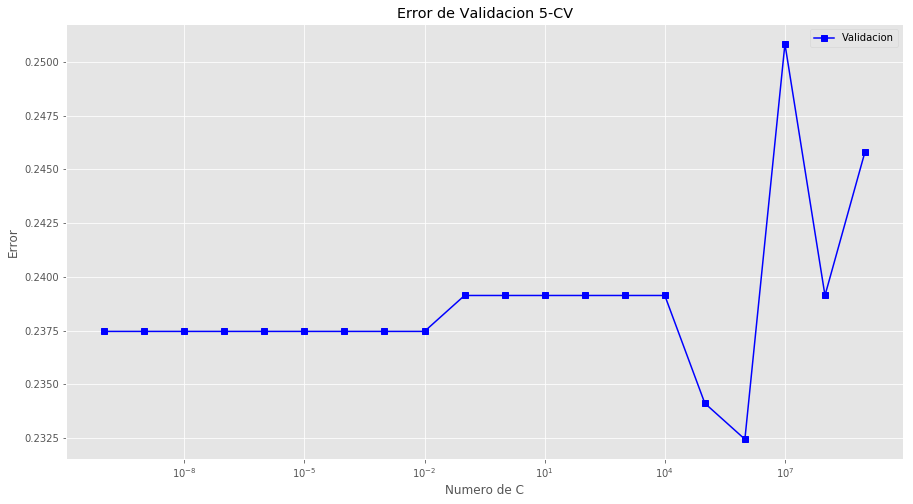

In [122]:
plot_errors_validation(cv_results_linear, min_C_value=1e-10)

Vamos ahora a calcular para cada convinacion de hiperparámetros su capacidad de clasificar los valores de test

In [15]:
unique_C_linear = cv_results_linear['param_C'].unique()

# Calcular los errores de test
test_errors_linear = {C: 0 for C in unique_C_linear}
test_errors_linear

{1e-10: 0,
 1e-09: 0,
 1e-08: 0,
 1e-07: 0,
 1e-06: 0,
 1e-05: 0,
 0.0001: 0,
 0.001: 0,
 0.01: 0,
 0.1: 0,
 1: 0,
 10: 0,
 100: 0,
 1000: 0,
 10000: 0,
 100000: 0,
 1000000: 0,
 10000000: 0,
 100000000: 0,
 1000000000: 0}

In [16]:
%%time

# Iterar sobre cada combinación de valores de C y gamma en test_errors
for index, row in cv_results_linear.iterrows():
    params = row['params']
    C_value = params['C']
    
    svm_model = SVC(random_state=SEED_VALUE, **params)
    svm_model.fit(X_train_scaled, Y_train)
    Y_pred_test = svm_model.predict(X_test_scaled)
    test_error = 1 - accuracy_score(Y_test, Y_pred_test)

    test_errors_linear[C_value] = test_error

CPU times: user 32min 3s, sys: 285 ms, total: 32min 4s
Wall time: 32min 4s


In [17]:
# with open('models_2/test_errors_linear.pkl', 'wb') as file:
#     pickle.dump(test_errors_linear, file)

In [18]:
with open('models_2/test_errors_linear.pkl', 'rb') as file:
    test_errors_linear = pickle.load(file)

In [19]:
test_errors_linear

{1e-10: 0.24,
 1e-09: 0.24,
 1e-08: 0.24,
 1e-07: 0.24,
 1e-06: 0.24,
 1e-05: 0.24,
 0.0001: 0.24,
 0.001: 0.24,
 0.01: 0.24,
 0.1: 0.24,
 1: 0.24,
 10: 0.24,
 100: 0.24,
 1000: 0.24,
 10000: 0.24,
 100000: 0.21999999999999997,
 1000000: 0.24,
 10000000: 0.2466666666666667,
 100000000: 0.2466666666666667,
 1000000000: 0.2466666666666667}

**Minimo valor de test y minimo valor para los valores de hiperparametro anteriores**

In [76]:
print("Minimo valor de test para el resultado de validacion cruzada: {}".format(test_errors_linear[1000000]))

Minimo valor de test para el resultado de validacion cruzada: 0.24


In [75]:
min_value_linear = min(test_errors_linear.values())
min_key_linear = [k for k, v in test_errors_linear.items() if v == min_value_linear][0]

print("Minimo valor de test. C_value: {}, valor: {}".format(min_key_linear, min_value_linear))

Minimo valor de test. C_value: 100000, valor: 0.22


In [85]:
def plot_errors_linear(cv_results_linear, test_errors_linear, min_C_value):
    plt.figure(figsize=(15, 8))

    # Ordenar los valores de C y obtener los correspondientes errores de validación
    sorted_subset = cv_results_linear[cv_results_linear['param_C'] >= min_C_value].sort_values(by='param_C')
    C_values = sorted_subset['param_C'].tolist()
    validation_scores = sorted_subset['mean_test_score'].tolist()

    # Gráfico de error de validación
    plt.plot(C_values, 
             validation_scores, 
             marker='s', 
             color='blue',
             label="Validacion")

    # Preparar y ordenar los valores de C para los errores de test
    test_C_values = sorted([C for C in test_errors_linear.keys() if C >= min_C_value])
    test_error_values = [test_errors_linear[C] for C in test_C_values]

    plt.plot(test_C_values, test_error_values, color='red', label="Test", marker='o')

    plt.title("Error de Validacion y Test 5-CV")
    plt.xlabel("Numero de C")
    plt.ylabel("Error")
    plt.xscale('log')  # Escala logarítmica para C
    plt.legend()
    plt.show()

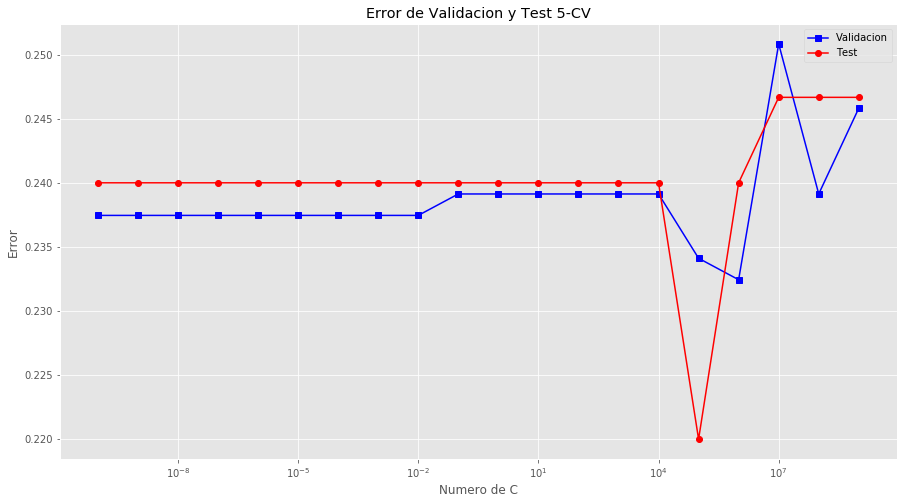

In [86]:
plot_errors_linear(cv_results_linear, test_errors_linear, min_C_value=1e-10)

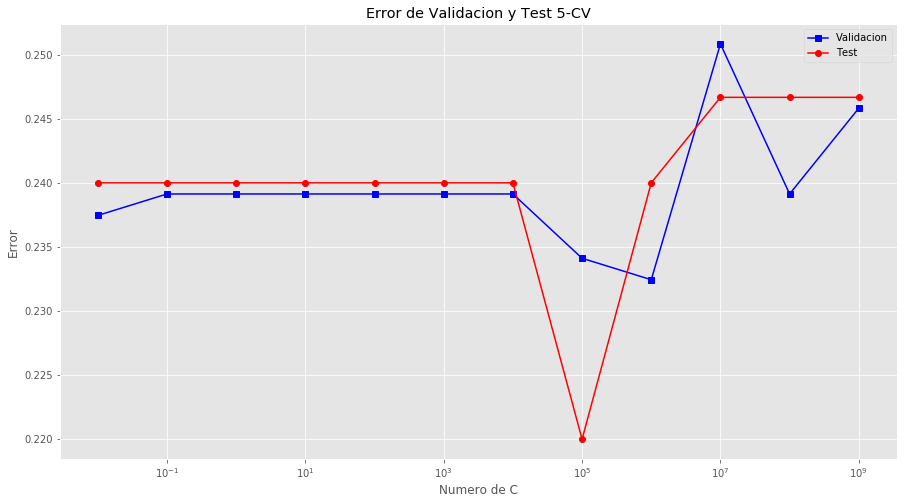

In [87]:
plot_errors_linear(cv_results_linear, test_errors_linear, min_C_value=1e-2)

## Poly

In [20]:
hyperparameters_poly = {
    'kernel': ['poly'],
    'C': c_poly,
    'gamma': [1],
    'degree': degree
}

hyperparameters_poly

{'C': [1e-06,
  1e-05,
  0.0001,
  0.001,
  0.01,
  0.1,
  1,
  10,
  100,
  1000,
  10000,
  100000],
 'degree': [2, 3, 4],
 'gamma': [1],
 'kernel': ['poly']}

In [ ]:
%%time
svm = SVC(random_state = SEED_VALUE)
modelCV_poly = GridSearchCV(
    svm,
    hyperparameters_poly,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1,
    verbose=4
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_poly.fit(X_train_scaled, Y_train)


Fitting 5 folds for each of 33 candidates, totalling 165 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  4.6min


In [ ]:
# Serializar y guardar tu modelo
# with open('models_2/modelCV_poly.pkl', 'wb') as file:
#     pickle.dump(modelCV_poly, file)

In [21]:
with open('models_2/modelCV_poly.pkl', 'rb') as file:
    modelCV_poly = pickle.load(file)

In [22]:
cv_results_poly = pd.DataFrame(modelCV_poly.cv_results_)
cv_results_poly['mean_test_score'] = 1 - cv_results_poly['mean_test_score']

In [81]:
cv_results_poly

mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0        0.008716         0.001363         0.237458          0.762543   1e-06   
1        0.019518         0.001540         0.239130          0.765466   1e-06   
2        0.013328         0.001316         0.237458          0.766301   1e-06   
3        0.007789         0.001118         0.237458          0.762543   1e-05   
4        0.004988         0.001125         0.237458          0.766301   1e-05   
5        0.007947         0.001212         0.239130          0.766719   1e-05   
6        0.005460         0.001094         0.239130          0.763795  0.0001   
7        0.005961         0.001095         0.235786          0.767136  0.0001   
8        0.036628         0.001233         0.240803          0.768809  0.0001   
9        0.005756         0.001100         0.237458          0.766301   0.001   
10       0.012304         0.001166         0.235786          0.769645   0.001   
11       0.106063         0.001813         0.237458          0.773409   0.001   
12       0.010130         0.001111         0.237458          0.766301    0.01   
13       0.029824         0.005522         0.232441          0.774662    0.01   
14       1.116145         0.011299         0.235786          0.773827    0.01   
15       0.077342         0.001212         0.237458          0.766301     0.1   
16       0.383224         0.001220         0.235786          0.776335     0.1   
17       9.032350         0.004544         0.235786          0.774245     0.1   
18       0.408034         0.012284         0.237458          0.766301       1   
19       2.702353         0.001402         0.230769          0.778005       1   
20     195.155075         0.017531         0.235786          0.773409       1   
21       2.594071         0.010731         0.237458          0.766301      10   
22      28.045347         0.013653         0.230769          0.778005      10   
23    1399.915751         0.002481         0.230769          0.772572      10   
24     224.696412         0.060116         0.237458          0.766301     100   
25     617.105873         0.026487         0.229097          0.775493     100   
26    5268.807127         0.002125         0.234114          0.775082     100   
27    1185.442101         0.052105         0.237458          0.766719    1000   
28    2200.714198         0.002032         0.227425          0.781360    1000   
29    8440.000389         0.002116         0.255853          0.767140    1000   
30    2557.639865         0.003670         0.237458          0.765467   10000   
31    3357.139188         0.004273         0.217391          0.785118   10000   
32   16099.245206         0.002032         0.317726          0.708155   10000   
33    3291.762593         0.015068         0.239130          0.767972  100000   
34    5623.400208         0.018550         0.285953          0.727848  100000   
35   15722.504056         0.001954         0.349498          0.683474  100000   

   param_degree param_gamma param_kernel  \
0             2           1         poly   
1             3           1         poly   
2             4           1         poly   
3             2           1         poly   
4             3           1         poly   
5             4           1         poly   
6             2           1         poly   
7             3           1         poly   
8             4           1         poly   
9             2           1         poly   
10            3           1         poly   
11            4           1         poly   
12            2           1         poly   
13            3           1         poly   
14            4           1         poly   
15            2           1         poly   
16            3           1         poly   
17            4           1         poly   
18            2           1         poly   
19            3           1         poly   
20            4           1         poly   
21            2           1         po

In [24]:
cv_results_poly.loc[:, [
    'param_C',
    'param_degree',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')

param_C param_degree  mean_test_score  std_test_score  rank_test_score
31   10000            3         0.217391        0.040126                1
28    1000            3         0.227425        0.025591                2
25     100            3         0.229097        0.013747                3
19       1            3         0.230769        0.013420                4
22      10            3         0.230769        0.013420                4
23      10            4         0.230769        0.014089                4
13    0.01            3         0.232441        0.007115                7
26     100            4         0.234114        0.021845                8
20       1            4         0.235786        0.010395                9
14    0.01            4         0.235786        0.010395                9
17     0.1            4         0.235786        0.010395                9
16     0.1            3         0.235786        0.013074                9
7   0.0001            3         0.235786        0.004200                9
10   0.001            3         0.235786        0.013074                9
21      10            2         0.237458        0.003744               15
27    1000            2         0.237458        0.003744               15
30   10000            2         0.237458        0.006490               15
24     100            2         0.237458        0.003744               15
0    1e-06            2         0.237458        0.002709               15
4    1e-05            3         0.237458        0.003744               15
15     0.1            2         0.237458        0.003744               15
12    0.01            2         0.237458        0.003744               15
11   0.001            4         0.237458        0.013186               15
9    0.001            2         0.237458        0.003744               15
18       1            2         0.237458        0.003744               15
3    1e-05            2         0.237458        0.002709               15
2    1e-06            4         0.237458        0.003744               15
6   0.0001            2         0.239130        0.003370               28
5    1e-05            4         0.239130        0.006792               28
1    1e-06            3         0.239130        0.003370               28
33  100000            2         0.239130        0.025226               28
8   0.0001            4         0.240803        0.014824               32
29    1000            4         0.255853        0.050246               33
34  100000            3         0.285953        0.053650               34
32   10000            4         0.317726        0.065541               35
35  100000            4         0.349498        0.048559               36

In [25]:
cv_results_poly_best = cv_results_poly[cv_results_poly['rank_test_score'] == 1]

cv_results_poly_best.loc[:, [
    'param_C',
    'param_degree',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(
    by='param_degree',
    ascending=True
).sort_values(
    by='param_C',
    ascending=True
).head()

param_C param_degree  mean_test_score  std_test_score  rank_test_score
31   10000            3         0.217391        0.040126                1

In [128]:
print("Minimo valor de test para el resultado de validacion cruzada: {}".format( test_errors_poly[3][10000]))

Minimo valor de test para el resultado de validacion cruzada: 0.233333333333


**Muestra las gráficas del error de entrenamiento con validación cruzada (5‐CV) frente al valor de los hiper‐parámetros**

In [129]:
def plot_errors_poly(cv_results_poly, min_C_value, degree_values):
    plt.figure(figsize=(15, 8))
    colors = cm.rainbow(np.linspace(0, 1, len(degree_values)))

    for i, degree_value in enumerate(degree_values):
        # Filtrar los resultados para una combinación específica de grado
        subset = cv_results_poly[cv_results_poly['param_degree'] == degree_value]

        if not subset.empty:
            # Ordenamos los valores de C y obtenemos los mean_test_score
            sorted_subset = subset[subset['param_C'] >= min_C_value].sort_values(by='param_C')
            C_values = sorted_subset['param_C'].tolist()
            validation_scores = sorted_subset['mean_test_score'].tolist()

            # Gráfico de mean_test_score
            plt.plot(C_values, 
                     validation_scores, 
                     marker='s', 
                     color=colors[i],
                     label="{} Degree - Validacion".format(degree_value))

    plt.title("Error de Validacion 5-CV para Diferentes Grados")
    plt.xlabel("Numero de C")
    plt.ylabel("Error")
    plt.xscale('log')  # Escala logarítmica para C
    plt.legend()
    plt.show()

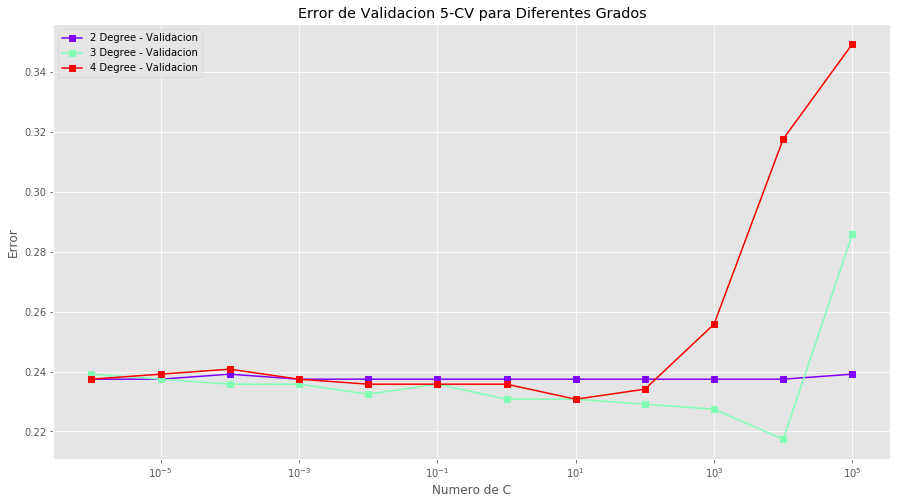

In [130]:
plot_errors_poly(cv_results_poly, min_C_value=1e-6, degree_values=[2, 3, 4])

In [26]:
unique_degree = cv_results_poly['param_degree'].unique()
unique_C = cv_results_poly['param_C'].unique()

# Calcular los errores de test
test_errors_poly = {degree: {C: 0 for C in unique_C} for degree in unique_degree}
test_errors_poly

{2: {1e-06: 0,
  1e-05: 0,
  0.0001: 0,
  0.001: 0,
  0.01: 0,
  0.1: 0,
  1: 0,
  10: 0,
  100: 0,
  1000: 0,
  10000: 0,
  100000: 0},
 3: {1e-06: 0,
  1e-05: 0,
  0.0001: 0,
  0.001: 0,
  0.01: 0,
  0.1: 0,
  1: 0,
  10: 0,
  100: 0,
  1000: 0,
  10000: 0,
  100000: 0},
 4: {1e-06: 0,
  1e-05: 0,
  0.0001: 0,
  0.001: 0,
  0.01: 0,
  0.1: 0,
  1: 0,
  10: 0,
  100: 0,
  1000: 0,
  10000: 0,
  100000: 0}}

In [27]:
%%time

# Iterar sobre cada combinación de valores de C y gamma en test_errors
for index, row in cv_results_poly.iterrows():
    params = row['params']
    C_value = params['C']
    degree_value = params['degree']
    
    svm_model = SVC(random_state=SEED_VALUE, **params)
    svm_model.fit(X_train_scaled, Y_train)
    Y_pred_test = svm_model.predict(X_test_scaled)
    test_error = 1 - accuracy_score(Y_test, Y_pred_test)

    test_errors_poly[degree_value][C_value] = test_error

CPU times: user 1h 26min 20s, sys: 743 ms, total: 1h 26min 20s
Wall time: 1h 26min 21s


In [28]:
# with open('models_2/test_errors_poly.pkl', 'wb') as file:
#     pickle.dump(test_errors_poly, file)

In [29]:
with open('models_2/test_errors_poly.pkl', 'rb') as file:
    test_errors_poly = pickle.load(file)

In [30]:
test_errors_poly

{2: {1e-06: 0.24,
  1e-05: 0.24,
  0.0001: 0.24,
  0.001: 0.23333333333333328,
  0.01: 0.23333333333333328,
  0.1: 0.23333333333333328,
  1: 0.23333333333333328,
  10: 0.23333333333333328,
  100: 0.23333333333333328,
  1000: 0.23333333333333328,
  10000: 0.22666666666666668,
  100000: 0.21999999999999997},
 3: {1e-06: 0.23333333333333328,
  1e-05: 0.23333333333333328,
  0.0001: 0.23333333333333328,
  0.001: 0.23333333333333328,
  0.01: 0.22666666666666668,
  0.1: 0.22666666666666668,
  1: 0.22666666666666668,
  10: 0.22666666666666668,
  100: 0.22666666666666668,
  1000: 0.21999999999999997,
  10000: 0.23333333333333328,
  100000: 0.30000000000000004},
 4: {1e-06: 0.23333333333333328,
  1e-05: 0.23333333333333328,
  0.0001: 0.23333333333333328,
  0.001: 0.22666666666666668,
  0.01: 0.22666666666666668,
  0.1: 0.22666666666666668,
  1: 0.22666666666666668,
  10: 0.22666666666666668,
  100: 0.22666666666666668,
  1000: 0.2666666666666667,
  10000: 0.30000000000000004,
  100000: 0.3199999

In [126]:
min_value_poly = float('inf')
min_keys_poly = None

for outer_key, inner_dict in test_errors_poly.items():
    for inner_key, value in inner_dict.items():
        if value < min_value_poly:
            min_value_poly = value
            min_keys_poly = (outer_key, inner_key)

print("Minimo valor de test. Degree: {}, C_value: {}, valor: {}".format(min_keys_poly[0], min_keys_poly[1], min_value_poly))

Minimo valor de test. Degree: 2, C_value: 100000, valor: 0.22


In [127]:
print("Minimo valor de test para el resultado de validacion cruzada: {}".format( test_errors_poly[3][10000]))

Minimo valor de test para el resultado de validacion cruzada: 0.233333333333


In [82]:
def plot_errors_poly(cv_results_poly, test_errors_poly, min_C_value, degree_values):
    plt.figure(figsize=(15, 8))
    colors = cm.rainbow(np.linspace(0, 1, len(degree_values)))

    for i, degree_value in enumerate(degree_values):
        # Filtrar los resultados para una combinación específica de gamma
        subset = cv_results_poly[cv_results_poly['param_degree'] == degree_value]

        if not subset.empty:
            # Ordenar los valores de C y obtener los correspondientes errores de validación
            sorted_subset = subset[subset['param_C'] >= min_C_value].sort_values(by='param_C')
            C_values = sorted_subset['param_C'].tolist()
            validation_scores = sorted_subset['mean_test_score'].tolist()

            # Gráfico de error de validación
            plt.plot(C_values, 
                     validation_scores, 
                     marker='s', 
                     color=colors[i],
                     label="{} Degree - Validacion".format(degree_value))

        # Preparar y ordenar los valores de gamma y los errores de test
        test_C_values = sorted([C for C in test_errors_poly[degree_value].keys() if C >= min_C_value])
        test_error_values = [test_errors_poly[degree_value][C] for C in test_C_values]

        plt.plot(test_C_values, test_error_values, color=colors[i], label="{} Degree - Test".format(degree_value), marker='o')

    plt.title("Error de Validacion y Test 5-CV")
    plt.xlabel("Numero de C")
    plt.ylabel("Error")
    plt.xscale('log')  # Escala logarítmica para C
    plt.legend()
    plt.show()

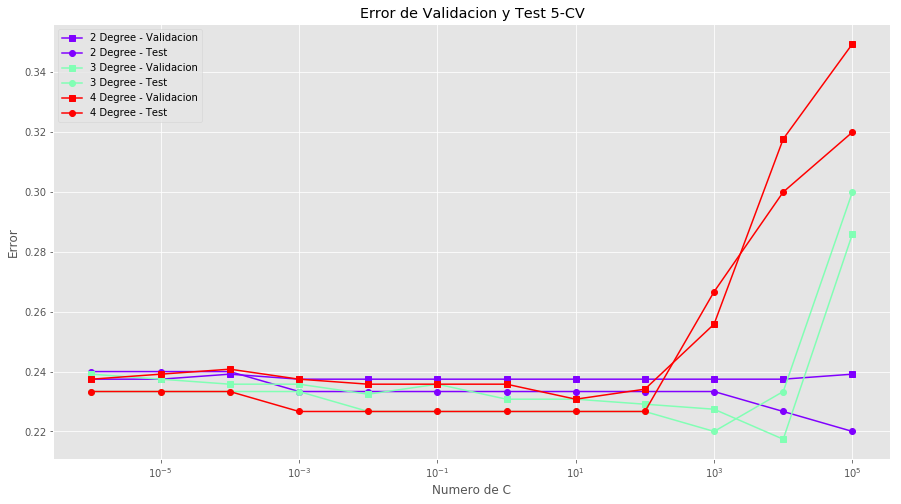

In [84]:
plot_errors_poly(cv_results_poly, test_errors_poly, min_C_value=1e-6, degree_values=unique_degree)

## RBF

In [31]:
hyperparameters_rbf = {
    'kernel': ['rbf'],
    'C': c,
    'gamma': gamma
}

hyperparameters_rbf

{'C': [1e-10,
  1e-09,
  1e-08,
  1e-07,
  1e-06,
  1e-05,
  0.0001,
  0.001,
  0.01,
  0.1,
  1,
  10,
  100,
  1000,
  10000,
  100000,
  1000000,
  10000000,
  100000000,
  1000000000],
 'gamma': [1e-10,
  1e-09,
  1e-08,
  1e-07,
  1e-06,
  1e-05,
  0.0001,
  0.001,
  0.01,
  0.1,
  1,
  10,
  100,
  1000,
  10000,
  100000,
  1000000,
  10000000,
  100000000,
  1000000000],
 'kernel': ['rbf']}

In [ ]:
%%time
svm = SVC(random_state = SEED_VALUE)
modelCV_rbf = GridSearchCV(
    svm,
    hyperparameters_rbf,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1,
    verbose=4
    )

# Ejecutamos el entrenamiento
np.random.seed(SEED_VALUE)
modelCV_rbf.fit(X_train_scaled, Y_train)


In [ ]:
# with open('models_2/modelCV_rbf.pkl', 'wb') as file:
#     pickle.dump(modelCV_rbf, file)

In [32]:
with open('models_2/modelCV_rbf.pkl', 'rb') as file:
    modelCV_rbf = pickle.load(file)

In [33]:
cv_results_rbf = pd.DataFrame(modelCV_rbf.cv_results_)
cv_results_rbf['mean_test_score'] = 1 - cv_results_rbf['mean_test_score']
cv_results_rbf

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0         0.013528         0.002268         0.237458          0.762543   
1         0.008619         0.002266         0.237458          0.762543   
2         0.008559         0.012104         0.237458          0.762543   
3         0.009196         0.003827         0.237458          0.762543   
4         0.008050         0.005580         0.237458          0.762543   
5         0.012144         0.005757         0.237458          0.762543   
6         0.008784         0.010274         0.237458          0.762543   
7         0.014935         0.008086         0.237458          0.762543   
8         0.011321         0.003880         0.237458          0.762543   
9         0.008138         0.008326         0.237458          0.762543   
10        0.008244         0.002057         0.237458          0.762543   
11        0.008803         0.003038         0.237458          0.762543   
12        0.014197         0.019296         0.237458          0.762543   
13        0.007106         0.003043         0.237458          0.762543   
14        0.006687         0.001720         0.237458          0.762543   
15        0.009132         0.001707         0.237458          0.762543   
16        0.006652         0.001692         0.237458          0.762543   
17        0.006574         0.001684         0.237458          0.762543   
18        0.012754         0.001697         0.237458          0.762543   
19        0.030650         0.001722         0.237458          0.762543   
20        0.007841         0.002013         0.237458          0.762543   
21        0.007895         0.008445         0.237458          0.762543   
22        0.010060         0.001994         0.237458          0.762543   
23        0.007981         0.004613         0.237458          0.762543   
24        0.008390         0.002028         0.237458          0.762543   
25        0.010879         0.002015         0.237458          0.762543   
26        0.008684         0.004645         0.237458          0.762543   
27        0.008131         0.002011         0.237458          0.762543   
28        0.008082         0.013480         0.237458          0.762543   
29        0.008073         0.002015         0.237458          0.762543   
..             ...              ...              ...               ...   
370     750.808174         0.002831         0.299331          0.898417   
371       0.576552         0.002314         0.285953          0.943979   
372       0.107453         0.003258         0.264214          0.943979   
373       0.082019         0.002617         0.249164          0.943979   
374       0.053880         0.002514         0.249164          0.943979   
375       0.065747         0.013463         0.249164          0.943979   
376       0.125930         0.002471         0.249164          0.943979   
377       0.049761         0.019833         0.249164          0.943979   
378       0.070732         0.002440         0.249164          0.943979   
379       0.070383         0.002530         0.249164          0.943979   
380       0.015534         0.001973         0.280936          0.709753   
381       0.028384         0.001784         0.341137          0.664308   
382       0.013779         0.001521         0.229097          0.774242   
383       0.031974         0.001553         0.237458          0.772153   
384       0.058823         0.017567         0.229097          0.773409   
385       0.343231         0.001701         0.225753          0.783019   
386       3.636013         0.001706         0.239130          0.773842   
387      32.864832         0.001811         0.230769          0.779669   
388     664.098455         0.024873         0.247492          0.782200   
389    3792.422678         0.007110         0.317726          0.746643   
390    1160.463243         0.021056         0.297659          0.878745   
391       0.482443         0.002313         0.285953          0.943979   
392      

In [34]:
cv_results_rbf.loc[:, [
    'param_C',
    'param_gamma',
    'mean_test_score',
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(by='rank_test_score')

param_C param_gamma  mean_test_score  std_test_score  rank_test_score
210           1           1         0.202341        0.023503                1
269        1000         0.1         0.205686        0.029920                2
249         100         0.1         0.209030        0.023211                3
308      100000        0.01         0.209030        0.027969                3
327     1000000       0.001         0.210702        0.031525                5
230          10           1         0.212375        0.032610                6
309      100000         0.1         0.215719        0.027539                7
328     1000000        0.01         0.217391        0.029086                8
346    10000000      0.0001         0.219064        0.034647                9
289       10000         0.1         0.219064        0.037381                9
229          10         0.1         0.220736        0.023560               11
326     1000000      0.0001         0.222408        0.023086               12
347    10000000       0.001         0.224080        0.032553               13
288       10000        0.01         0.224080        0.024613               13
325     1000000       1e-05         0.225753        0.019070               15
385  1000000000       1e-05         0.225753        0.044904               15
364   100000000       1e-06         0.225753        0.021282               15
367   100000000       0.001         0.227425        0.041242               18
344    10000000       1e-06         0.227425        0.014409               18
343    10000000       1e-07         0.227425        0.032251               18
211           1          10         0.227425        0.007371               18
323     1000000       1e-07         0.227425        0.019295               18
307      100000       0.001         0.229097        0.020135               23
268        1000        0.01         0.229097        0.020135               23
382  1000000000       1e-08         0.229097        0.017712               23
384  1000000000       1e-06         0.229097        0.016726               23
342    10000000       1e-08         0.229097        0.015838               23
387  1000000000       0.001         0.230769        0.051520               28
287       10000       0.001         0.230769        0.014401               28
324     1000000       1e-06         0.230769        0.016167               28
..          ...         ...              ...             ...              ...
332     1000000         100         0.264214        0.027883              370
392  1000000000         100         0.264214        0.027883              370
372   100000000         100         0.264214        0.027883              370
252         100         100         0.264214        0.027883              370
272        1000         100         0.264214        0.027883              370
352    10000000         100         0.264214        0.027883              370
232          10         100         0.264214        0.027883              370
292       10000         100         0.264214        0.027883              370
360   100000000       1e-10         0.264214        0.036762              370
271        1000          10         0.275920        0.031640              380
291       10000          10         0.277592        0.038557              381
251         100          10         0.280936        0.037532              382
380  1000000000       1e-10         0.280936        0.066196              382
331     1000000          10         0.285953        0.037887              384
351    10000000          10         0.285953        0.037887              384
391  1000000000          10         0.285953        0.037887              384
371   100000000          10         0.285953        0.037887              384
311      100000          10         0.285953        0.037887              384
350    10000000           1         0.289298        0.031531              389
390  1000000000           1   

In [35]:
cv_results_rbf_best = cv_results_rbf[cv_results_rbf['rank_test_score'] == 1]

cv_results_rbf_best.loc[:, [
    'param_C',
    'param_gamma',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
    ]
].sort_values(
    by='param_gamma', 
    ascending=True
).sort_values(
    by='param_C', 
    ascending=True
).head()

param_C param_gamma  mean_test_score  std_test_score  rank_test_score
210       1           1         0.202341        0.023503                1

**Muestra las gráficas del error de entrenamiento con validación cruzada (5‐CV) frente al valor de los hiper‐parámetros**

In [131]:
def plot_errors_rbf(cv_results_rbf, min_C_value, gamma_values):
    plt.figure(figsize=(15, 8))
    colors = cm.rainbow(np.linspace(0, 1, len(gamma_values)))

    for i, gamma_value in enumerate(gamma_values):
        # Filtramos los resultados para una combinación específica de gamma
        subset = cv_results_rbf[cv_results_rbf['param_gamma'] == gamma_value]

        if not subset.empty:
            # Ordenanos los valores de C y obtenemos los mean_test_score
            sorted_subset = subset[subset['param_C'] >= min_C_value].sort_values(by='param_C')
            C_values = sorted_subset['param_C'].tolist()
            validation_scores = sorted_subset['mean_test_score'].tolist()

            # Gráfico de mean_test_score
            plt.plot(C_values, 
                     validation_scores, 
                     marker='s', 
                     color=colors[i],
                     label="Gamma {} - Validacion".format(gamma_value))

    plt.title("Error de Validacion 5-CV para Diferentes Valores de Gamma")
    plt.xlabel("Numero de C")
    plt.ylabel("Error")
    plt.xscale('log')  # Escala logarítmica para C
    plt.legend()
    plt.show()

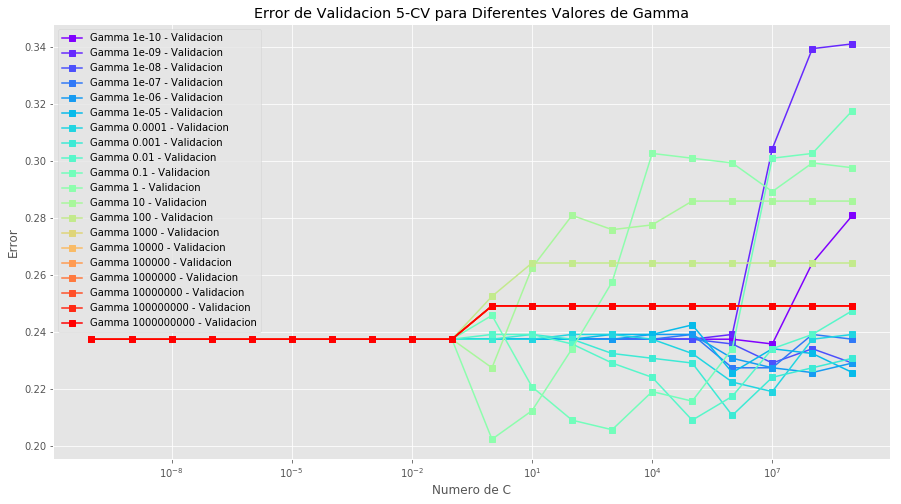

In [134]:
plot_errors_rbf(cv_results_rbf, min_C_value=1e-10, gamma_values=unique_gamma)

In [135]:
plot_errors_rbf(cv_results_rbf, min_C_value=1e-2, gamma_values=[1e-3, 1e-2, 1e-1, 1])

In [36]:
unique_gamma = cv_results_rbf['param_gamma'].unique()
unique_C = cv_results_rbf['param_C'].unique()

# Calcular los errores de test
test_errors_rbf = {gamma: {C: 0 for C in unique_C} for gamma in unique_gamma}

In [37]:
%%time

# Iterar sobre cada combinación de valores de C y gamma en test_errors
for index, row in cv_results_rbf.iterrows():
    params = row['params']
    C_value = params['C']
    gamma_value = params['gamma']
    
    svm_model = SVC(random_state=SEED_VALUE, **params)
    svm_model.fit(X_train_scaled, Y_train)
    Y_pred_test = svm_model.predict(X_test_scaled)
    test_error = 1 - accuracy_score(Y_test, Y_pred_test)

    test_errors_rbf[gamma_value][C_value] = test_error

CPU times: user 1h 37min 22s, sys: 892 ms, total: 1h 37min 22s
Wall time: 1h 37min 23s


In [38]:
# with open('models_2/test_errors_rbf.pkl', 'wb') as file:
#     pickle.dump(test_errors_rbf, file)

In [39]:
with open('models_2/test_errors_rbf.pkl', 'rb') as file:
    test_errors_rbf = pickle.load(file)

In [67]:
test_errors_rbf

{1e-10: {1e-10: 0.24,
  1e-09: 0.24,
  1e-08: 0.24,
  1e-07: 0.24,
  1e-06: 0.24,
  1e-05: 0.24,
  0.0001: 0.24,
  0.001: 0.24,
  0.01: 0.24,
  0.1: 0.24,
  1: 0.24,
  10: 0.24,
  100: 0.24,
  1000: 0.24,
  10000: 0.24,
  100000: 0.24,
  1000000: 0.24,
  10000000: 0.22666666666666668,
  100000000: 0.2533333333333333,
  1000000000: 0.2666666666666667},
 1e-09: {1e-10: 0.24,
  1e-09: 0.24,
  1e-08: 0.24,
  1e-07: 0.24,
  1e-06: 0.24,
  1e-05: 0.24,
  0.0001: 0.24,
  0.001: 0.24,
  0.01: 0.24,
  0.1: 0.24,
  1: 0.24,
  10: 0.24,
  100: 0.24,
  1000: 0.24,
  10000: 0.24,
  100000: 0.24,
  1000000: 0.23333333333333328,
  10000000: 0.2866666666666666,
  100000000: 0.33333333333333337,
  1000000000: 0.33333333333333337},
 1e-08: {1e-10: 0.24,
  1e-09: 0.24,
  1e-08: 0.24,
  1e-07: 0.24,
  1e-06: 0.24,
  1e-05: 0.24,
  0.0001: 0.24,
  0.001: 0.24,
  0.01: 0.24,
  0.1: 0.24,
  1: 0.24,
  10: 0.24,
  100: 0.24,
  1000: 0.24,
  10000: 0.24,
  100000: 0.24,
  1000000: 0.22666666666666668,
  100000

In [78]:
print("Minimo valor de test para el resultado de validacion cruzada: {}".format(test_errors_rbf[1][1]))

Minimo valor de test para el resultado de validacion cruzada: 0.226666666667


In [73]:
min_value_rbf = float('inf')
min_keys_rbf = None

for outer_key, inner_dict in test_errors_rbf.items():
    for inner_key, value in inner_dict.items():
        if value < min_value_rbf:
            min_value_rbf = value
            min_keys_rbf = (outer_key, inner_key)

print("Minimo valor de test. Gamma: {}, C_value: {}, valor: {}".format(min_keys_rbf[0], min_keys_rbf[1], min_value_rbf))

Minimo valor de test. Gamma: 0.1, C_value: 10, valor: 0.2


In [142]:
def plot_errors_rbf(cv_results_rbf, test_errors_rbf, min_C_value, gamma_values):
    plt.figure(figsize=(15, 8))
    colors = cm.rainbow(np.linspace(0, 1, len(gamma_values)))

    for i, gamma_value in enumerate(gamma_values):
        # Filtrar los resultados para una combinación específica de gamma
        subset = cv_results_rbf[cv_results_rbf['param_gamma'] == gamma_value]

        if not subset.empty:
            # Ordenar los valores de C y obtener los correspondientes errores de validación
            sorted_subset = subset[subset['param_C'] >= min_C_value].sort_values(by='param_C')
            C_values = sorted_subset['param_C'].tolist()
            validation_scores = sorted_subset['mean_test_score'].tolist()

            # Gráfico de error de validación
            plt.plot(C_values, 
                     validation_scores, 
                     marker='s', 
                     color=colors[i],
                     label="{} Gamma - Validacion".format(gamma_value))

        # Preparar y ordenar los valores de gamma y los errores de test
        test_C_values = sorted([C for C in test_errors_rbf[gamma_value].keys() if C >= min_C_value])
        test_error_values = [test_errors_rbf[gamma_value][C] for C in test_C_values]

        plt.plot(test_C_values, test_error_values, color=colors[i], label="{} Gamma - Test".format(gamma_value), marker='o')

    plt.title("Error de Validacion y Test 5-CV")
    plt.xlabel("Numero de C")
    plt.ylabel("Error")
    plt.xscale('log')  # Escala logarítmica para C
    plt.legend()
    plt.show()

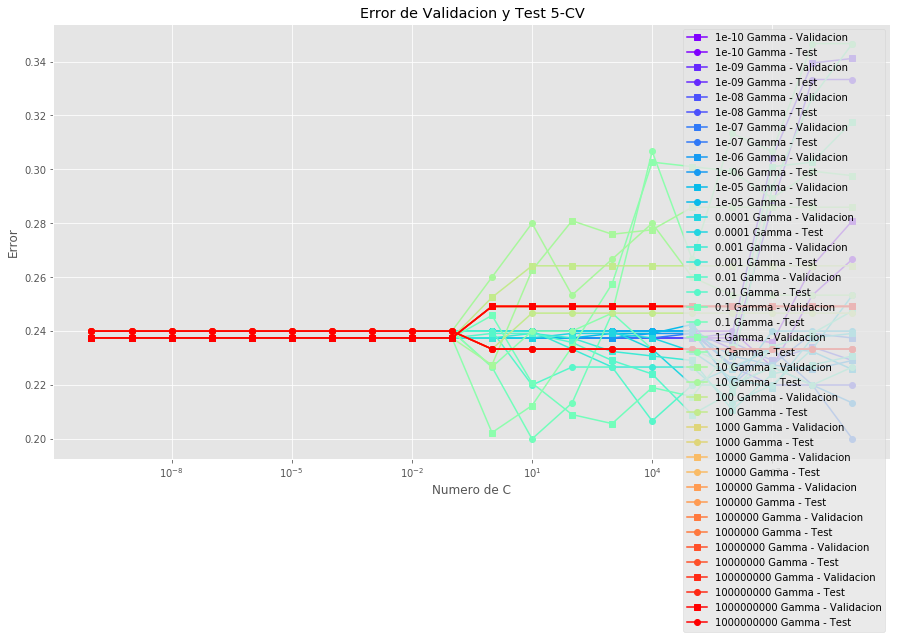

In [143]:
plot_errors_rbf(cv_results_rbf, test_errors_rbf, min_C_value=1e-10, gamma_values=unique_gamma)

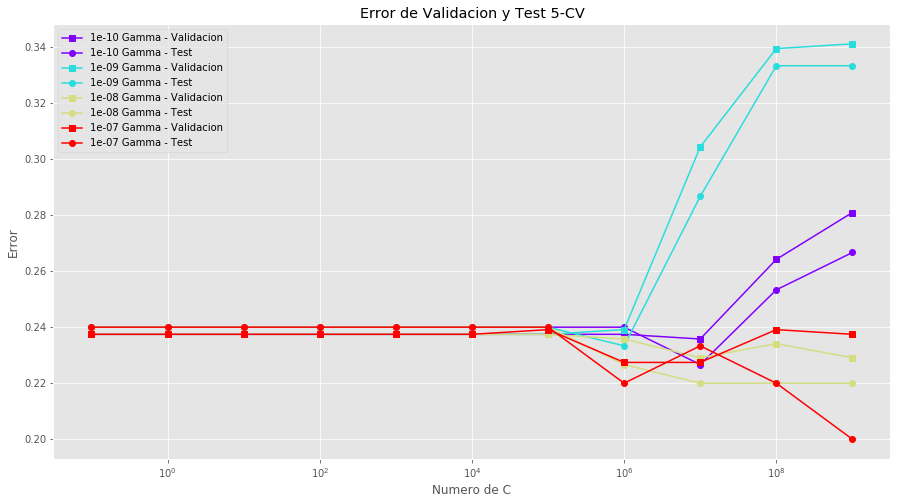

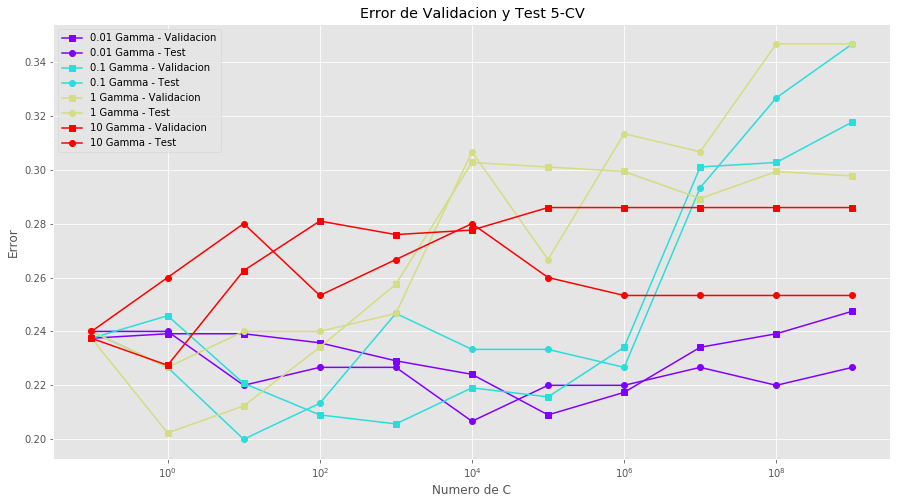

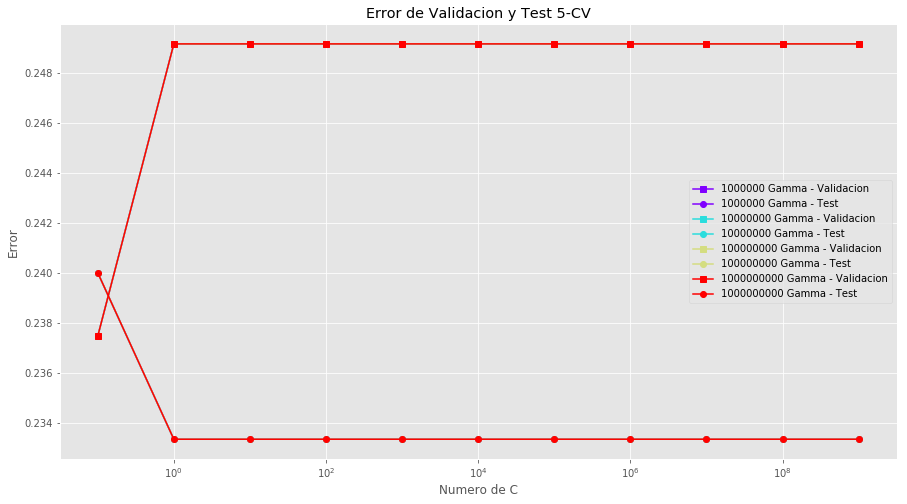

In [144]:
for i in range(0, len(unique_gamma), 4):
    gamma_segment = unique_gamma[i:i+4]
    plot_errors_rbf(cv_results_rbf, test_errors_rbf, min_C_value=1e-1, gamma_values=gamma_segment)